# AUC (Área bajo la curva ROC): Guía Completa para Científicos de Datos

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# Estilo general
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("=== AUC-ROC Analysis — Simulación de Detección de Fraude ===\n")


=== AUC-ROC Analysis — Simulación de Detección de Fraude ===



In [6]:
X, y = make_classification(
    n_samples=10_000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=1,
    weights=[0.95, 0.05],  # Dataset desbalanceado
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Distribución de clases (entrenamiento):")
print(f"Clase 0 (No fraude): {np.sum(y_train == 0)} ({np.mean(y_train == 0):.1%})")
print(f"Clase 1 (Fraude):    {np.sum(y_train == 1)} ({np.mean(y_train == 1):.1%})")


Distribución de clases (entrenamiento):
Clase 0 (No fraude): 6628 (94.7%)
Clase 1 (Fraude):    372 (5.3%)


In [8]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    results[name] = {
        'auc': auc_score,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'probabilities': y_proba
    }

    print(f"{name:20}: AUC = {auc_score:.4f}")


Random Forest       : AUC = 0.9597
Logistic Regression : AUC = 0.9443


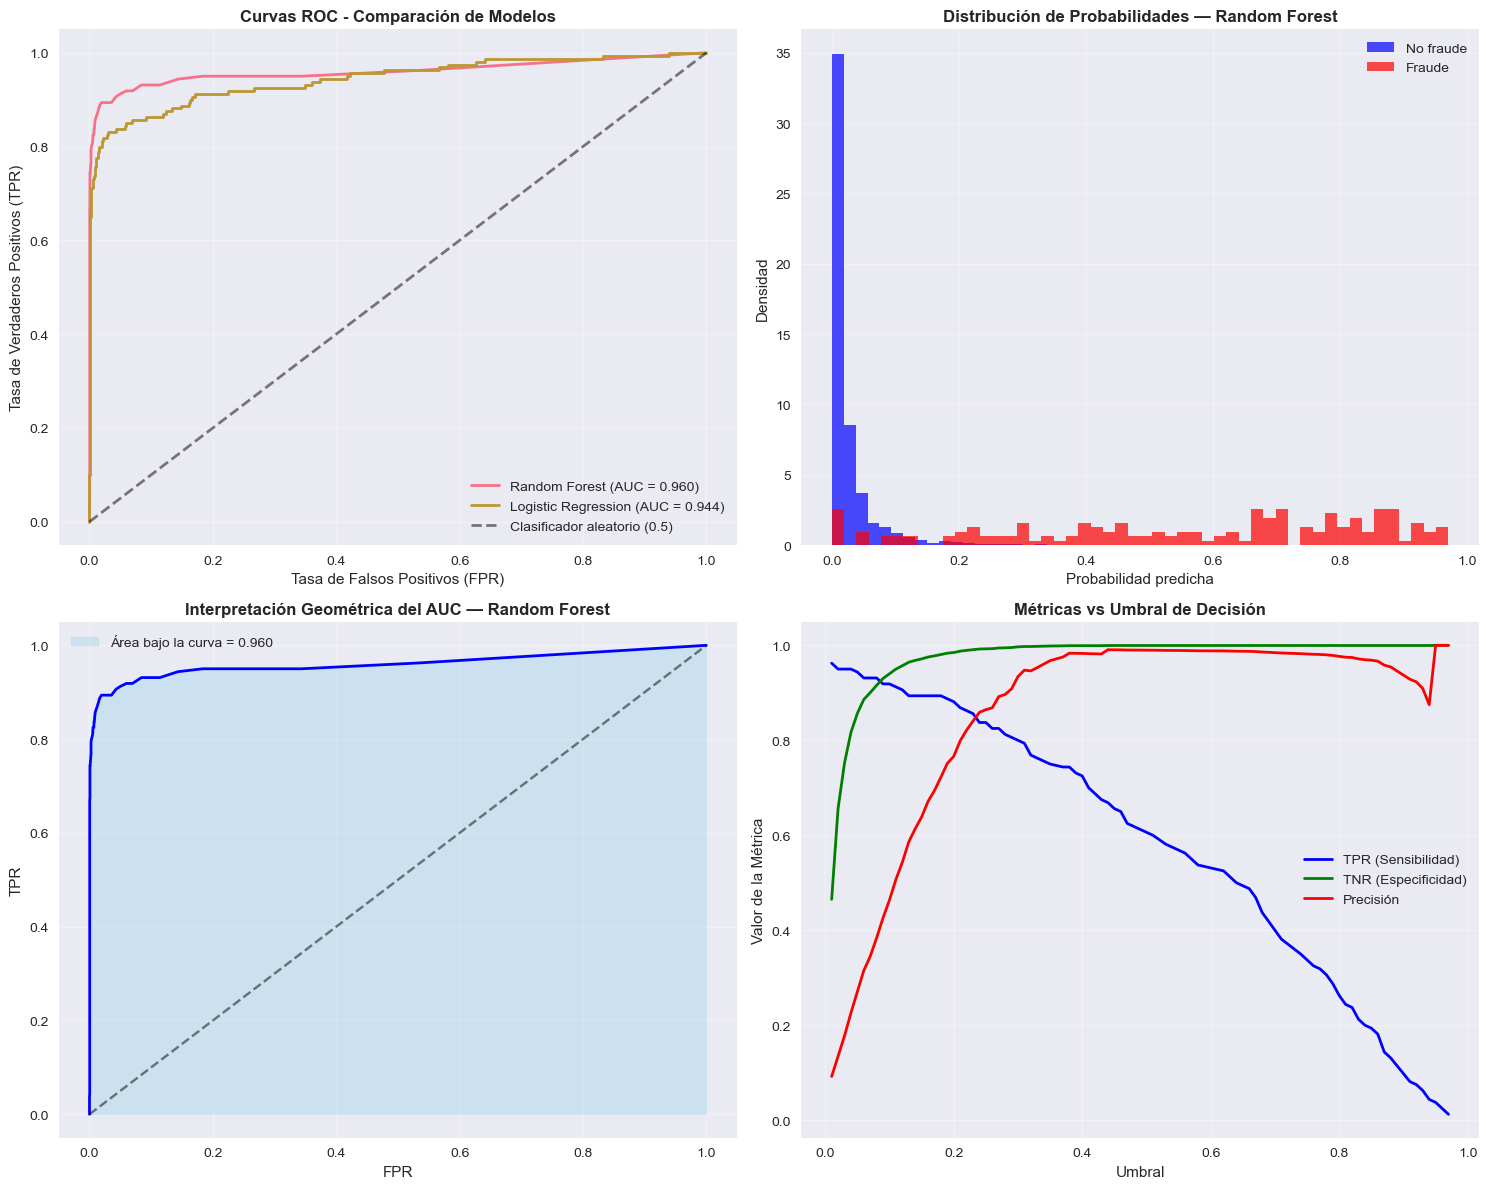

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
best_model = max(results.keys(), key=lambda k: results[k]['auc'])
best_result = results[best_model]
probas = best_result['probabilities']

# --- 1. Curvas ROC comparativas ---
ax1 = axes[0, 0]
for name, res in results.items():
    ax1.plot(res['fpr'], res['tpr'], lw=2, label=f"{name} (AUC = {res['auc']:.3f})")
ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label="Clasificador aleatorio (0.5)")
ax1.set_title("Curvas ROC - Comparación de Modelos", fontweight='bold')
ax1.set_xlabel("Tasa de Falsos Positivos (FPR)")
ax1.set_ylabel("Tasa de Verdaderos Positivos (TPR)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- 2. Distribución de probabilidades ---
ax2 = axes[0, 1]
ax2.hist(probas[y_test == 0], bins=50, alpha=0.7, label='No fraude', color='blue', density=True)
ax2.hist(probas[y_test == 1], bins=50, alpha=0.7, label='Fraude', color='red', density=True)
ax2.set_title(f"Distribución de Probabilidades — {best_model}", fontweight='bold')
ax2.set_xlabel("Probabilidad predicha")
ax2.set_ylabel("Densidad")
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- 3. Interpretación geométrica del AUC ---
ax3 = axes[1, 0]
ax3.fill_between(best_result['fpr'], best_result['tpr'], alpha=0.3, color='skyblue',
                 label=f"Área bajo la curva = {best_result['auc']:.3f}")
ax3.plot(best_result['fpr'], best_result['tpr'], 'b-', lw=2)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_title(f"Interpretación Geométrica del AUC — {best_model}", fontweight='bold')
ax3.set_xlabel("FPR")
ax3.set_ylabel("TPR")
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- 4. Análisis de umbrales ---
ax4 = axes[1, 1]
thresholds = best_result['thresholds']
tpr = best_result['tpr']
fpr = best_result['fpr']

precision_scores = []
for thresh in thresholds:
    y_pred_thresh = (probas >= thresh).astype(int)
    denom = np.sum(y_pred_thresh)
    precision_scores.append(
        np.sum((y_pred_thresh == 1) & (y_test == 1)) / denom if denom > 0 else 0
    )

# Ajuste correcto: recortamos TPR/FPR al tamaño de thresholds[:-1]
tpr_plot = tpr[:-1]
fpr_plot = fpr[:-1]
precision_plot = precision_scores[:-1]
thresholds_plot = thresholds[:-1]

ax4.plot(thresholds_plot, tpr_plot, 'b-', lw=2, label='TPR (Sensibilidad)')
ax4.plot(thresholds_plot, 1 - fpr_plot, 'g-', lw=2, label='TNR (Especificidad)')
ax4.plot(thresholds_plot, precision_plot, 'r-', lw=2, label='Precisión')

ax4.set_title("Métricas vs Umbral de Decisión", fontweight='bold')
ax4.set_xlabel("Umbral")
ax4.set_ylabel("Valor de la Métrica")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
print(f"\n--- Análisis de Umbral Óptimo para {best_model} ---")

youden = best_result['tpr'] + (1 - best_result['fpr']) - 1
optimal_idx = np.argmax(youden[:-1])
optimal_threshold = best_result['thresholds'][optimal_idx]

print(f"Umbral óptimo (Youden’s Index): {optimal_threshold:.4f}")
print(f"TPR: {best_result['tpr'][optimal_idx]:.4f}")
print(f"FPR: {best_result['fpr'][optimal_idx]:.4f}")

# Clasificación con umbral óptimo
y_pred_opt = (probas >= optimal_threshold).astype(int)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_opt, target_names=['No Fraude', 'Fraude']))



--- Análisis de Umbral Óptimo para Random Forest ---
Umbral óptimo (Youden’s Index): 0.1800
TPR: 0.8938
FPR: 0.0194

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.99      0.98      0.99      2840
      Fraude       0.72      0.89      0.80       160

    accuracy                           0.98      3000
   macro avg       0.86      0.94      0.89      3000
weighted avg       0.98      0.98      0.98      3000



In [14]:
print("\n--- Interpretación Probabilística del AUC ---")

pos_scores = probas[y_test == 1]
neg_scores = probas[y_test == 0]

comparisons = 0
correct = 0

for pos in pos_scores:
    for neg in neg_scores:
        comparisons += 1
        if pos > neg:
            correct += 1
        elif pos == neg:
            correct += 0.5  # Empate

manual_auc = correct / comparisons
sklearn_auc = best_result['auc']

print(f"AUC calculado manualmente: {manual_auc:.4f}")
print(f"AUC de sklearn: {sklearn_auc:.4f}")
print(f"Diferencia: {abs(manual_auc - sklearn_auc):.6f}")



--- Interpretación Probabilística del AUC ---
AUC calculado manualmente: 0.9597
AUC de sklearn: 0.9597
Diferencia: 0.000000
